# Dataset Integration and Clustering

### 1. Import Required Packages 
### 2. Load in Prior Data
### 3. Determine top 2000 variable genes for clustering - Drop Non-Variable genes
### 4. Integration with scVI
### 5. Calculate neighbors and Conduct Leiden Clustering 
### 6. Calculate neighbors and Conduct Leiden Clustering  on adata with ALL GENES
### 7. Notes and Conclusions


## <br> 1. Import Required Packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scvi
import anndata as ad

from scvi.model.utils import mde
from scipy import sparse
from anndata import AnnData
from anndata.experimental.multi_files import AnnCollection

[rank: 0] Global seed set to 0


Set figure parameters.

In [2]:
sc.set_figure_params(figsize=(10, 8))
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'
pd.options.display.max_colwidth = 100

## <br> 2. Load in Data

In [3]:
adata = ad.read_h5ad('./Adata_Objects/01a_integrated_libraries_post-normalized.h5ad')

In [4]:
print(adata)

AnnData object with n_obs × n_vars = 263074 × 22917
    obs: 'Dose', 'Time', 'OrigIdent', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'Barcode', 'OrigIdent-Barcode', 'Seurat_Celltype', 'doublet_scores', 'predicted_doublets', 'doublet_info'
    uns: 'OrigIdent_colors', 'doublet_info_colors', 'log1p'
    layers: 'counts', 'log1p_counts'


Save original adata for analysis with all genes

In [5]:
adata_ALL_GENES = adata.copy()

## 3. Determine top 2000 variable genes for clustering - Drop Non-Variable genes

In [6]:
sc.pp.highly_variable_genes(
    adata,
    flavor="cell_ranger",
    n_top_genes=2000,
    layer="counts",
    batch_key="OrigIdent",
    subset=True,
)

/mnt/home/cholicog/miniconda3/envs/scvi-env/lib/python3.9/site-packages/numba/core/dispatcher.py:289: UserWarning: Numba extension module 'sparse._numba_extension' failed to load due to 'ModuleNotFoundError(No module named 'numba.targets')'.
  entrypoints.init_all()


## 4. Integration with scVI

In [7]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    batch_key="OrigIdent",
    categorical_covariate_keys=["Dose", "Time"],
    continuous_covariate_keys=["pct_counts_mt"],
)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Train Model

In [8]:
HV_Genes_model = scvi.model.SCVI(adata, n_layers=2, n_latent=40)

In [9]:
HV_Genes_model.train()

/mnt/home/cholicog/miniconda3/envs/scvi-env/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /mnt/home/cholicog/miniconda3/envs/scvi-env/lib/pyth ...
  rank_zero_warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/mnt/home/cholicog/miniconda3/envs/scvi-env/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /mnt/home/cholicog/miniconda3/envs/scvi-env/lib/pyth ...
  rank_zero_warn(


Epoch 30/30: 100%|██████████| 30/30 [2:32:56<00:00, 113.98s/it, loss=395, v_num=1]  

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 30/30: 100%|██████████| 30/30 [2:32:56<00:00, 305.88s/it, loss=395, v_num=1]


Save Model

In [10]:
HV_Genes_model.save("./Models/HV_Genes_Latent_40/", save_anndata=True)

Load Model

In [ ]:
#HV_Genes_model = scvi.model.SCVI.load("./Models/HV_Genes_Latent_30/")

Save trained data to AnnData Objects

In [11]:
adata.obsm["X_scVI"] = HV_Genes_model.get_latent_representation()
adata_ALL_GENES.obsm["X_scVI"] = HV_Genes_model.get_latent_representation()

Store the normalized values back in the anndata.

In [12]:
adata.layers["scvi_normalized"] = HV_Genes_model.get_normalized_expression(library_size=10e4)

To visualize here we use minimum distortion embeddings, which for now can be thought of as an alternative of UMAP that is GPU-accelerated 

## 5. Calculate neighbors and Conduct Leiden Clustering 

/mnt/home/cholicog/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


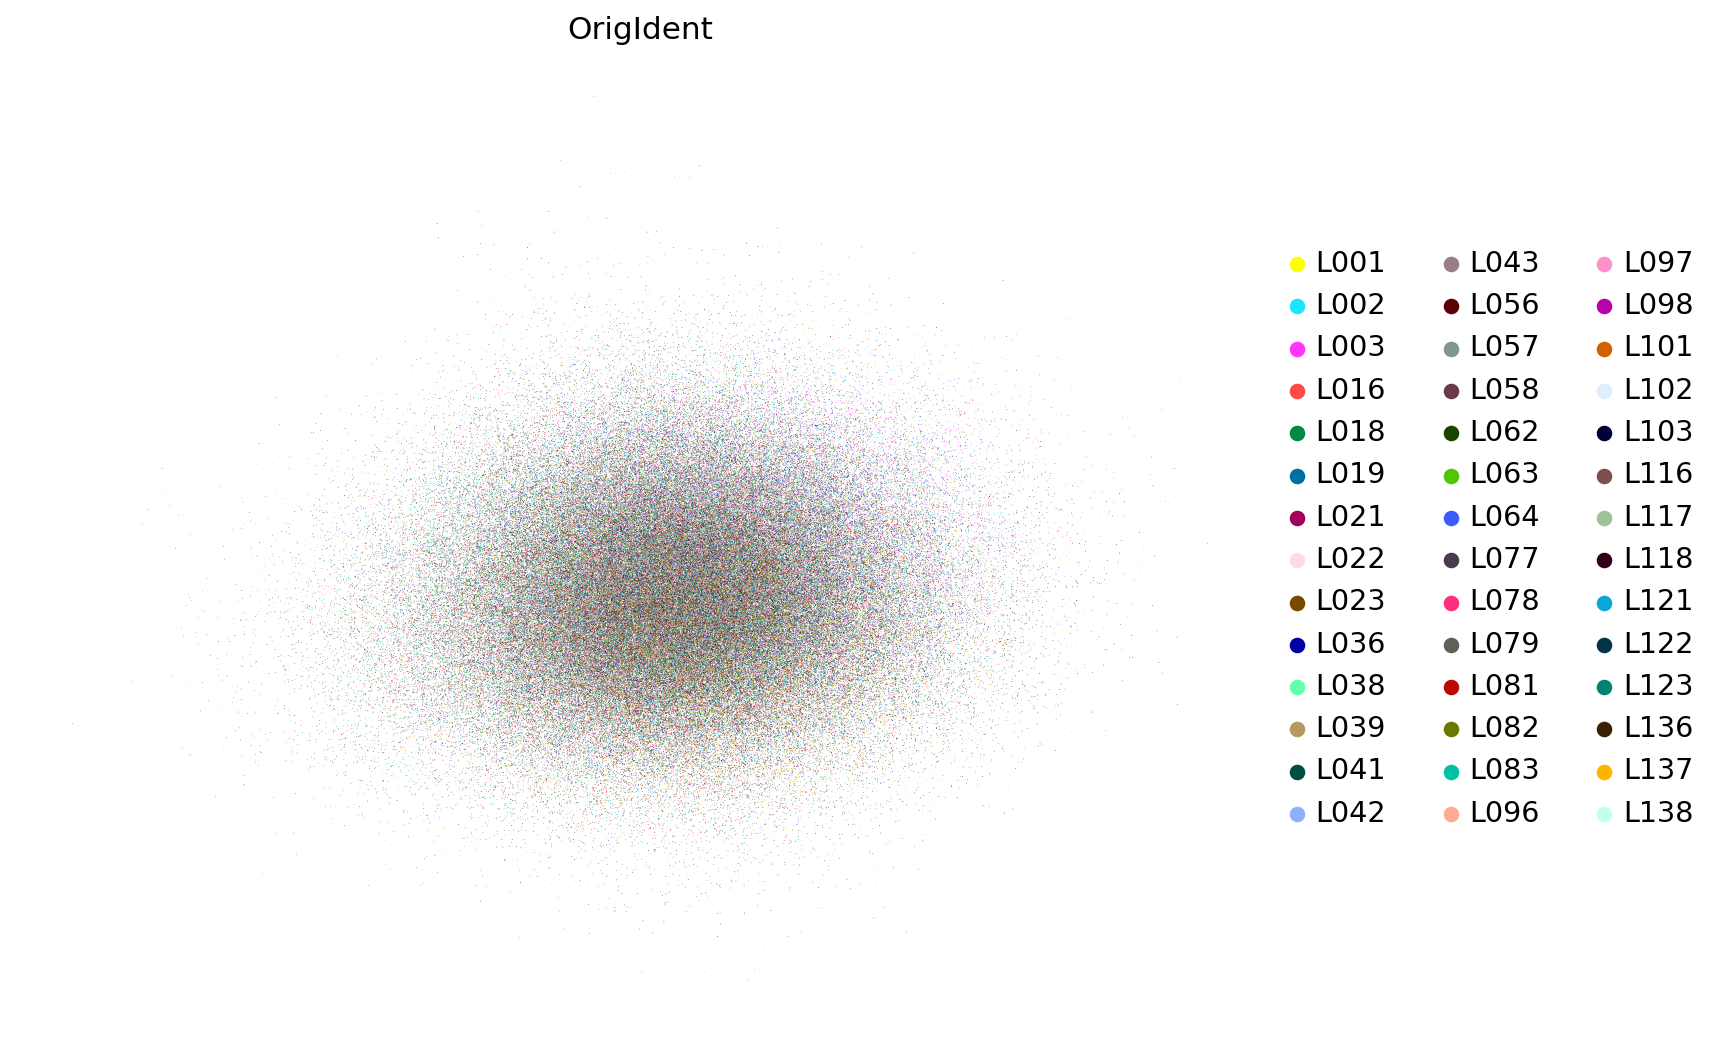

In [13]:
sc.pl.embedding(
    adata,
    basis="X_scVI",
    color=["OrigIdent"],
    frameon=False,
    ncols=1,
)

In [14]:
sc.pp.neighbors(adata, 
                use_rep="X_scVI",
                random_state=5,
                method='umap')

2023-05-26 16:28:03.522975: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:7704] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-05-26 16:28:03.523034: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-05-26 16:28:03.523054: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1520] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-05-26 16:28:05.661405: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [15]:
sc.tl.umap(adata, 
           min_dist=0.1,
           random_state=5)

/mnt/home/cholicog/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


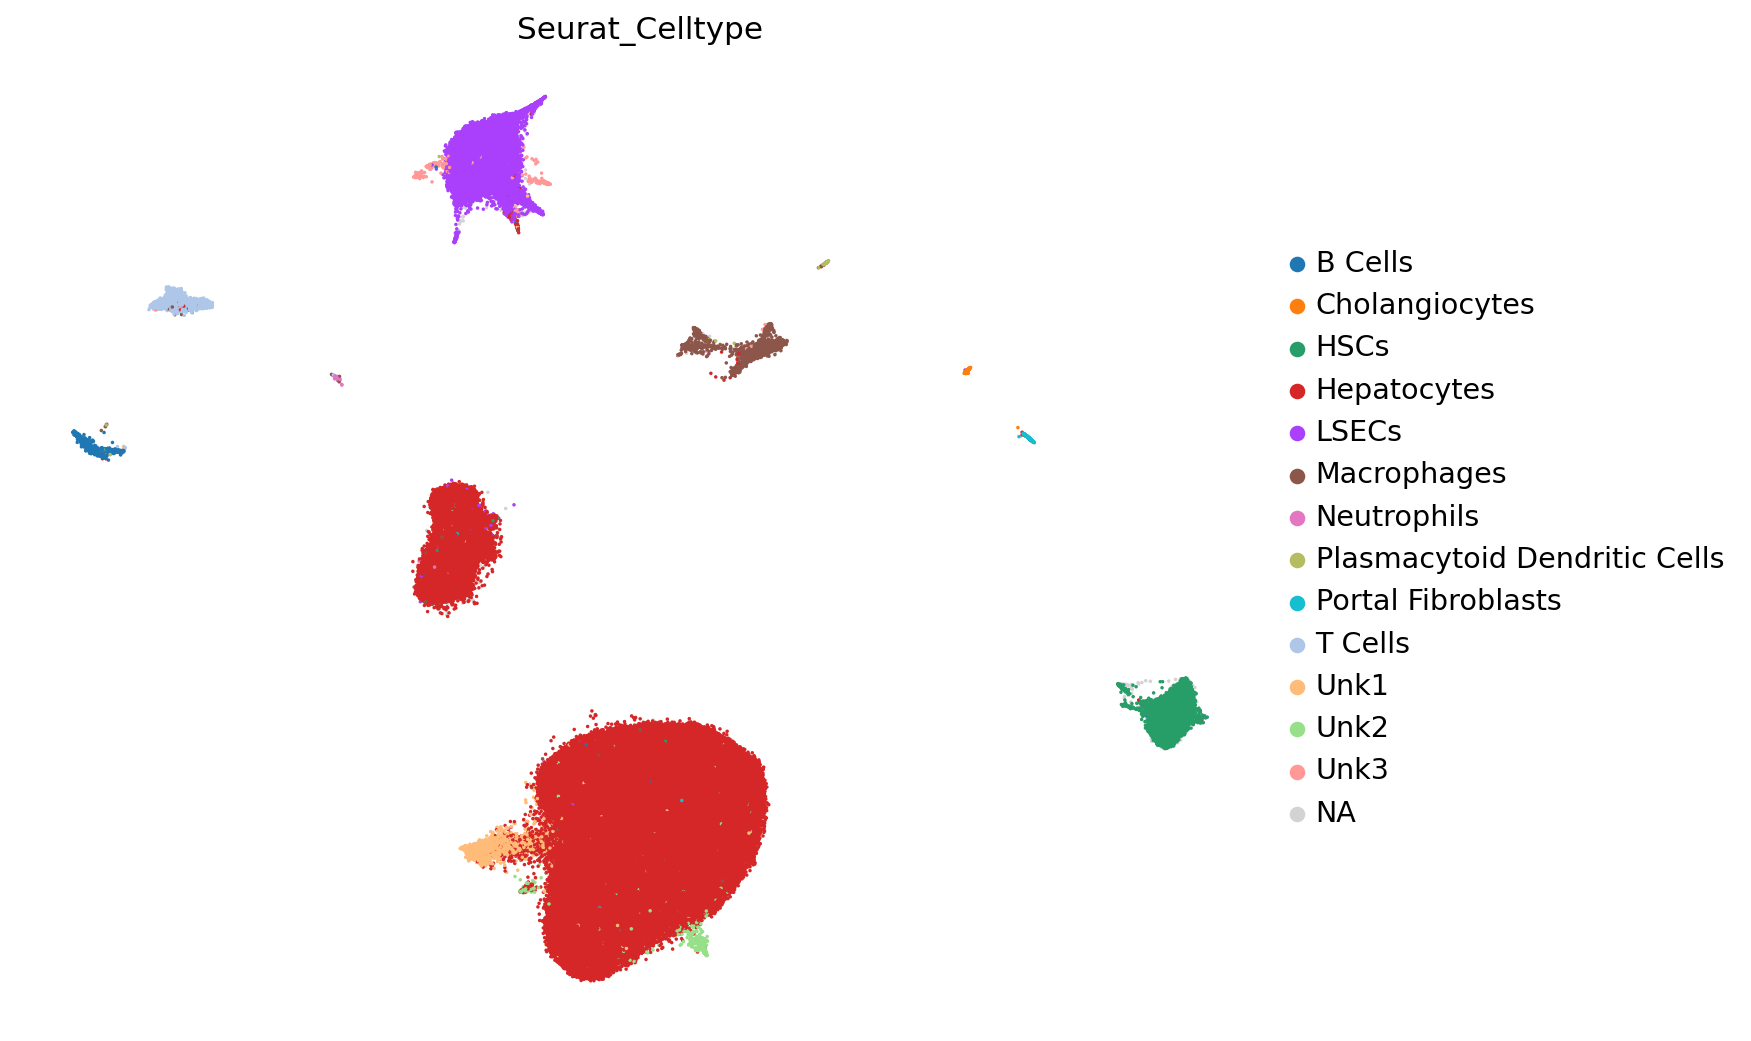

In [16]:
sc.pl.umap(
    adata,
    color=["Seurat_Celltype"],
    frameon=False,
    size=10
)

In [17]:
sc.tl.leiden(adata, key_added="leiden_scVI_res_0.05", resolution=0.05)
sc.tl.leiden(adata, key_added="leiden_scVI_res_0.1", resolution=0.1)
sc.tl.leiden(adata, key_added="leiden_scVI_res_0.25", resolution=0.25)
sc.tl.leiden(adata, key_added="leiden_scVI_res_0.5", resolution=0.5)
sc.tl.leiden(adata, key_added="leiden_scVI_res_0.75", resolution=0.75)
sc.tl.leiden(adata, key_added="leiden_scVI_res_1.5", resolution=1.5)

/mnt/home/cholicog/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


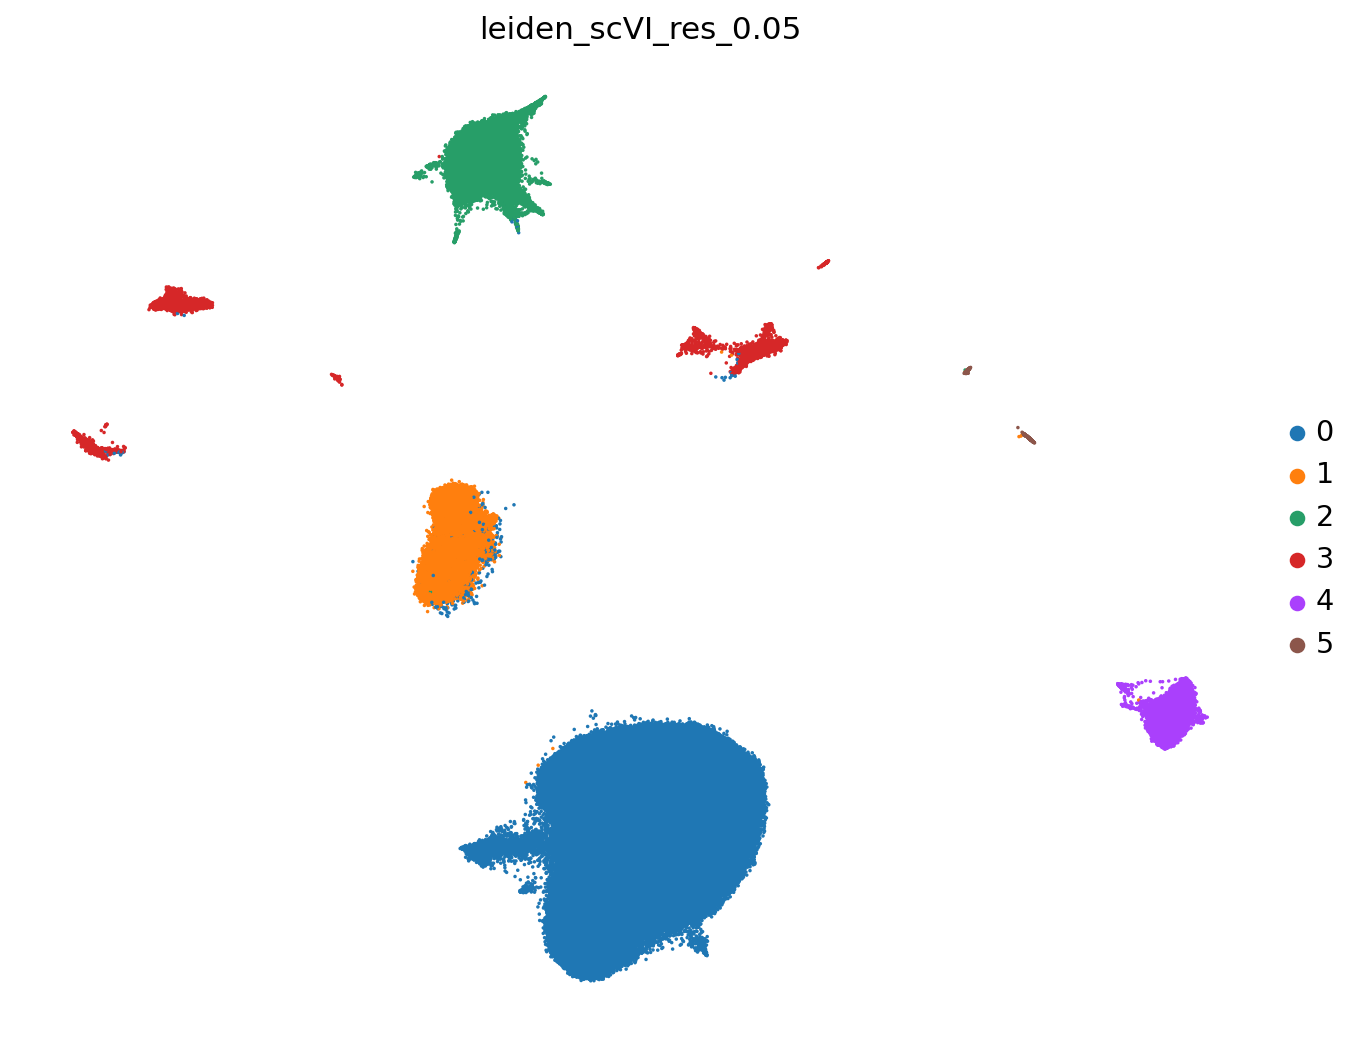

In [18]:
sc.pl.umap(
    adata,
    color=["leiden_scVI_res_0.05"],
    frameon=False,
    size=10,
    save='_Clustering-Res_0.05.pdf'
)

/mnt/home/cholicog/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


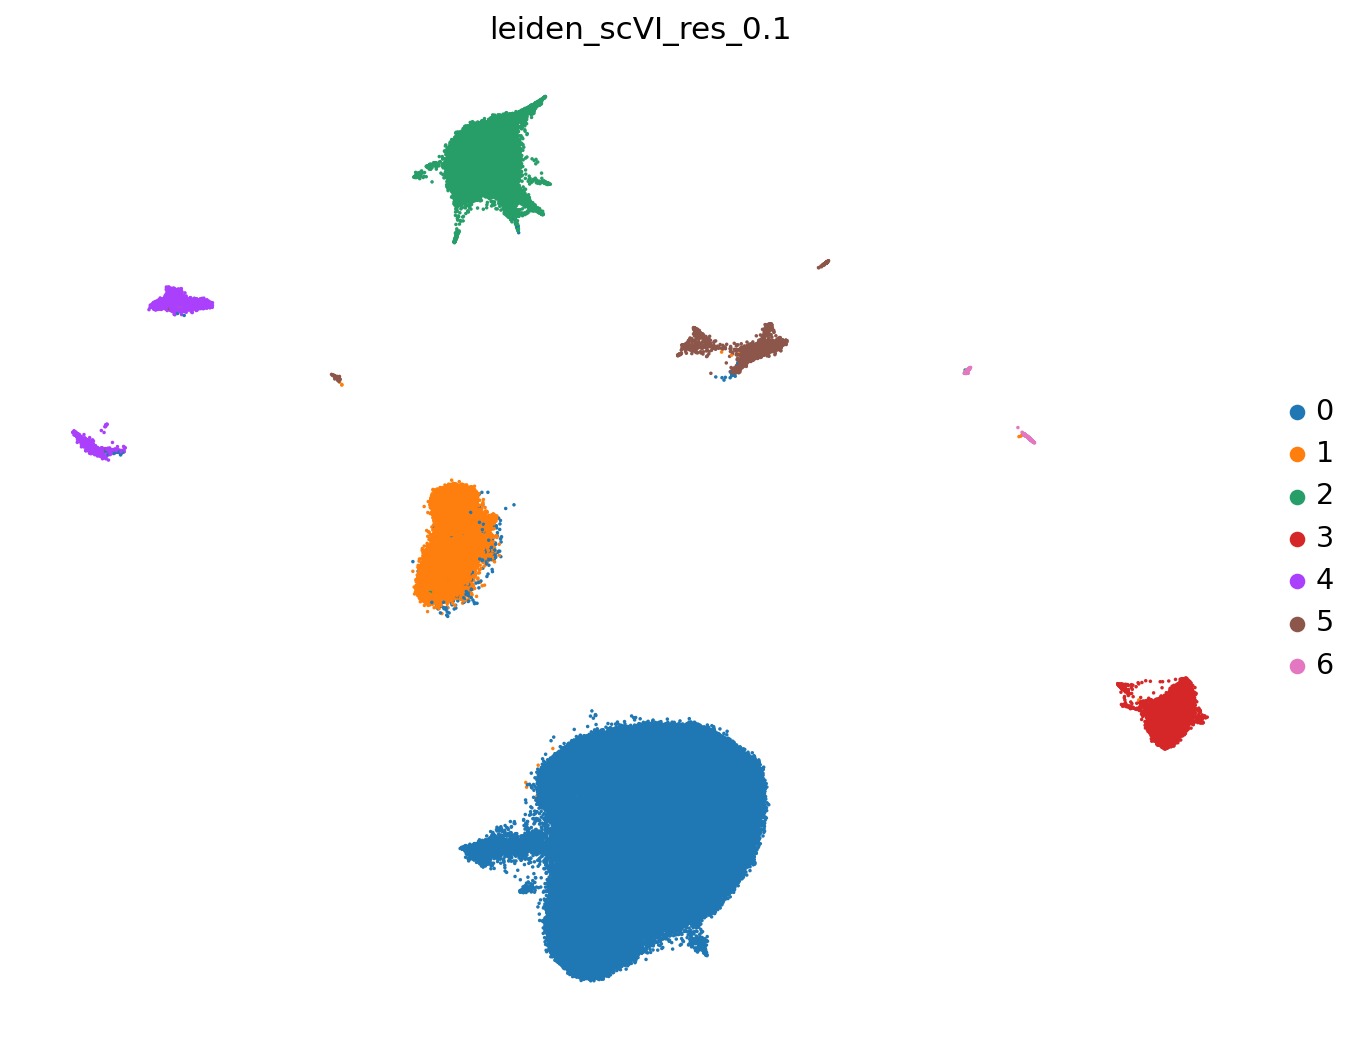

In [19]:
sc.pl.umap(
    adata,
    color=["leiden_scVI_res_0.1"],
    frameon=False,
    size=10,
    save='_Clustering-Res_0.1.pdf'
)

/mnt/home/cholicog/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


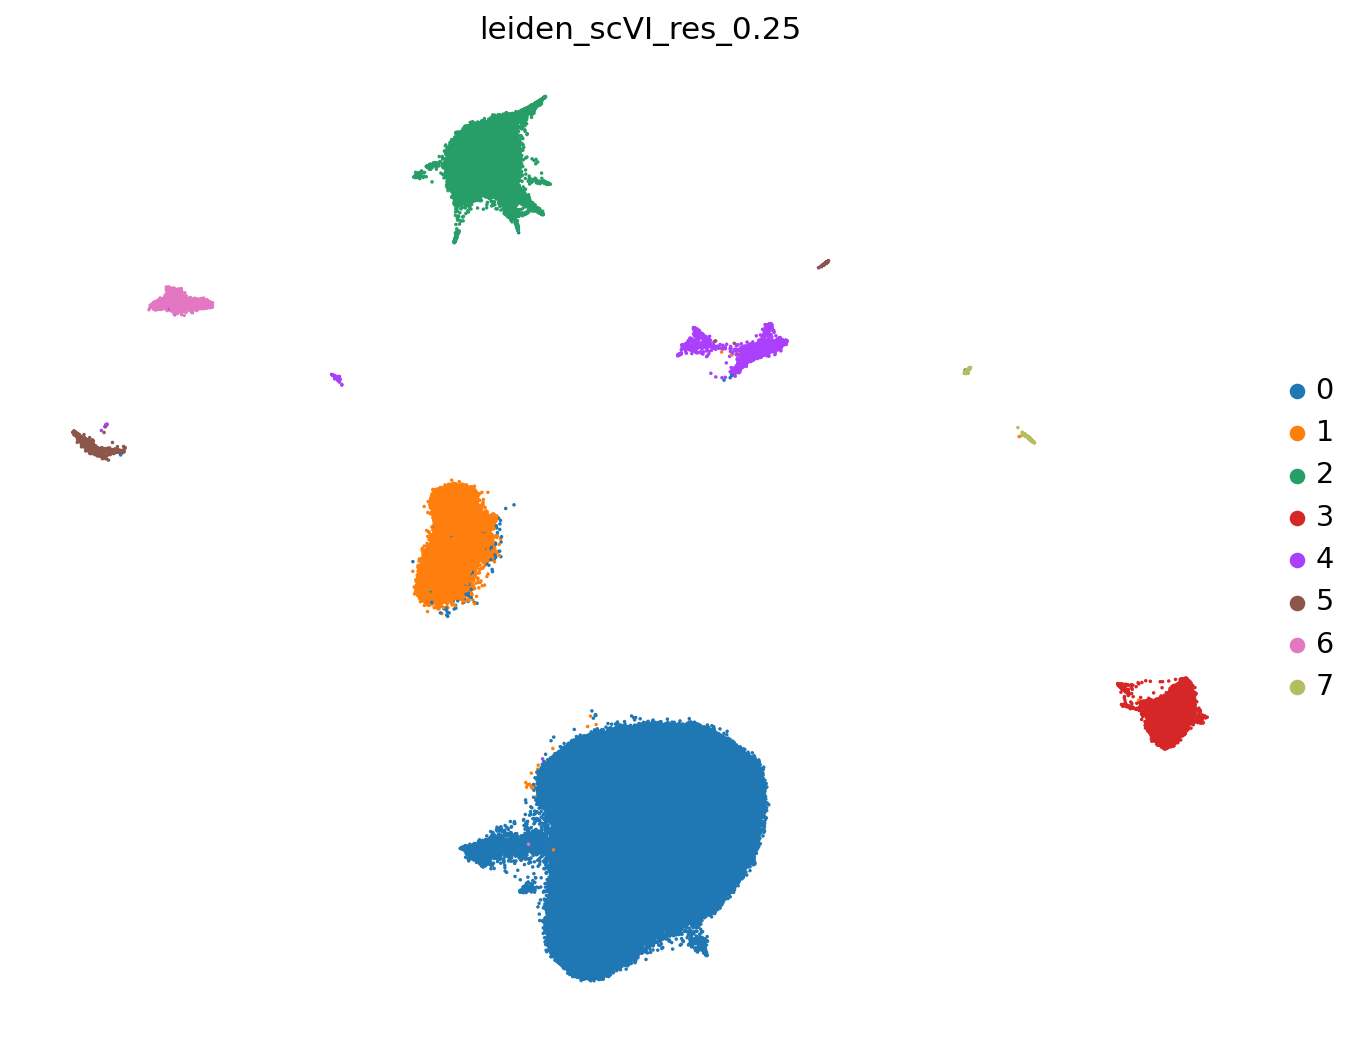

In [20]:
sc.pl.umap(
    adata,
    color=["leiden_scVI_res_0.25"],
    frameon=False,
    size=10,
    save='_Clustering-Res_0.25.pdf'
)

/mnt/home/cholicog/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


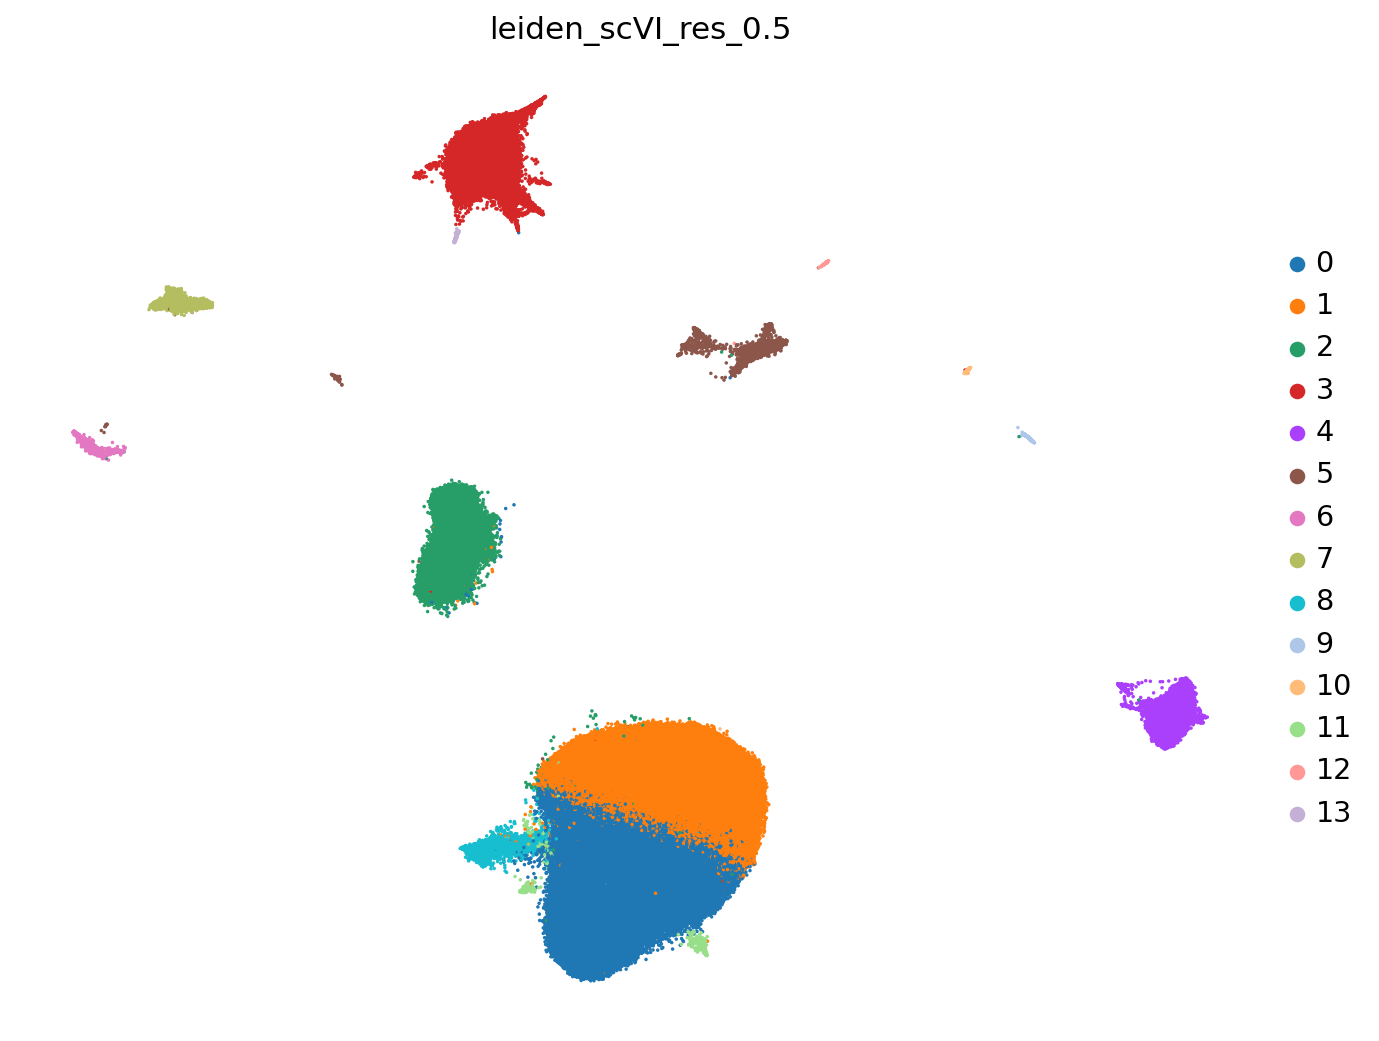

In [21]:
sc.pl.umap(
    adata,
    color=["leiden_scVI_res_0.5"],
    frameon=False,
    size=10,
    save='_Clustering-Res_0.5.pdf'
)

/mnt/home/cholicog/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


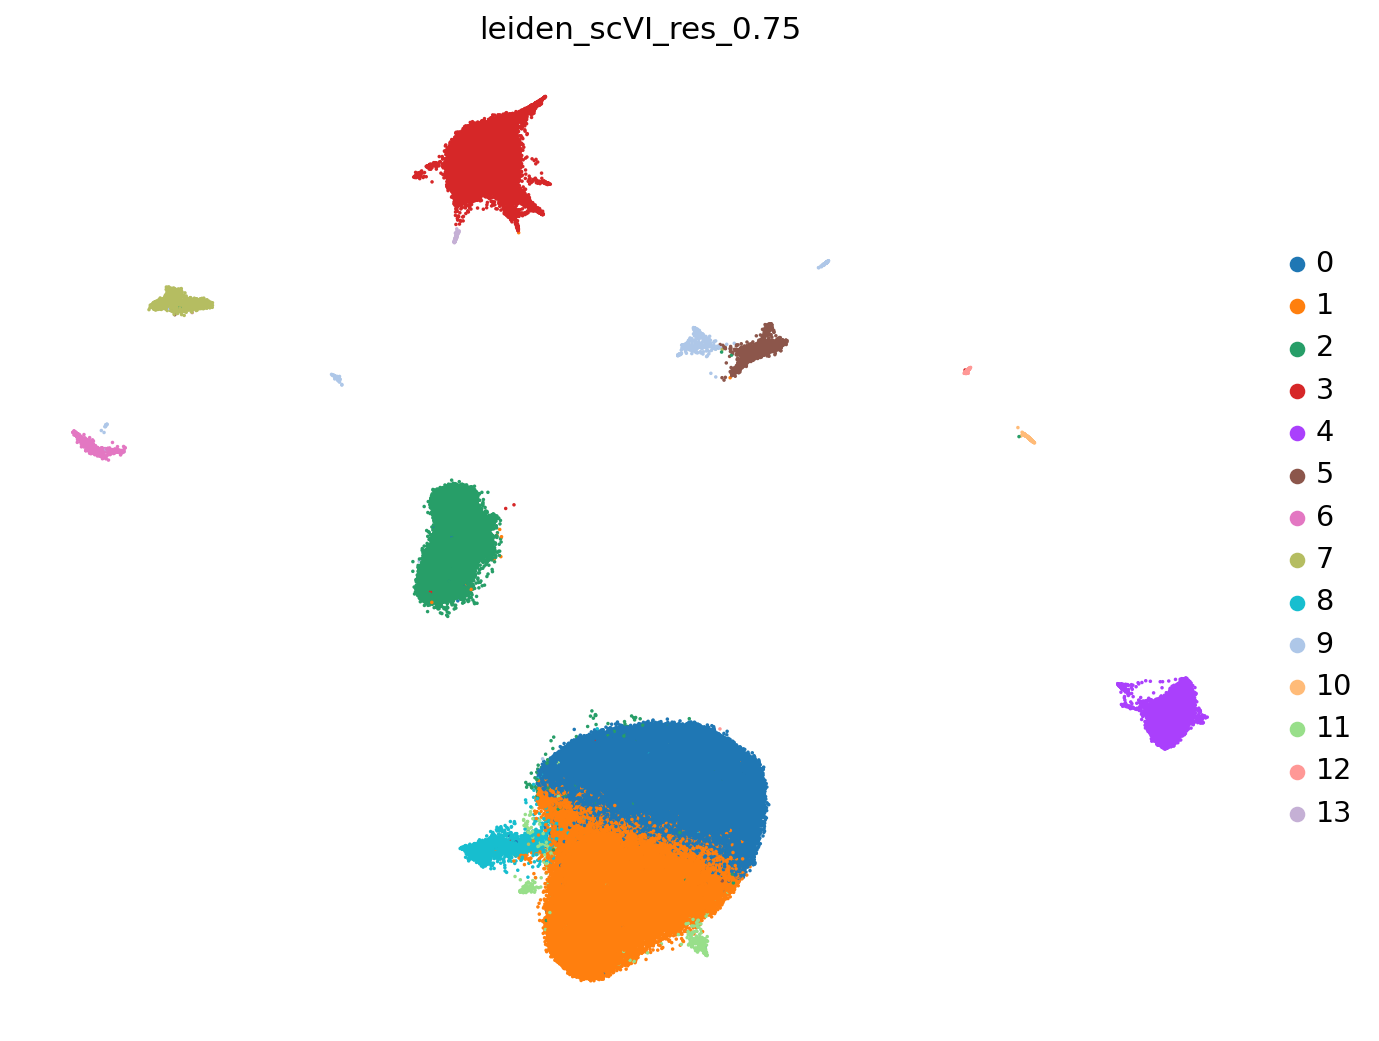

In [22]:
sc.pl.umap(
    adata,
    color=["leiden_scVI_res_0.75"],
    frameon=False,
    size=10,
    save='_Clustering-Res_0.75.pdf'
)

/mnt/home/cholicog/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


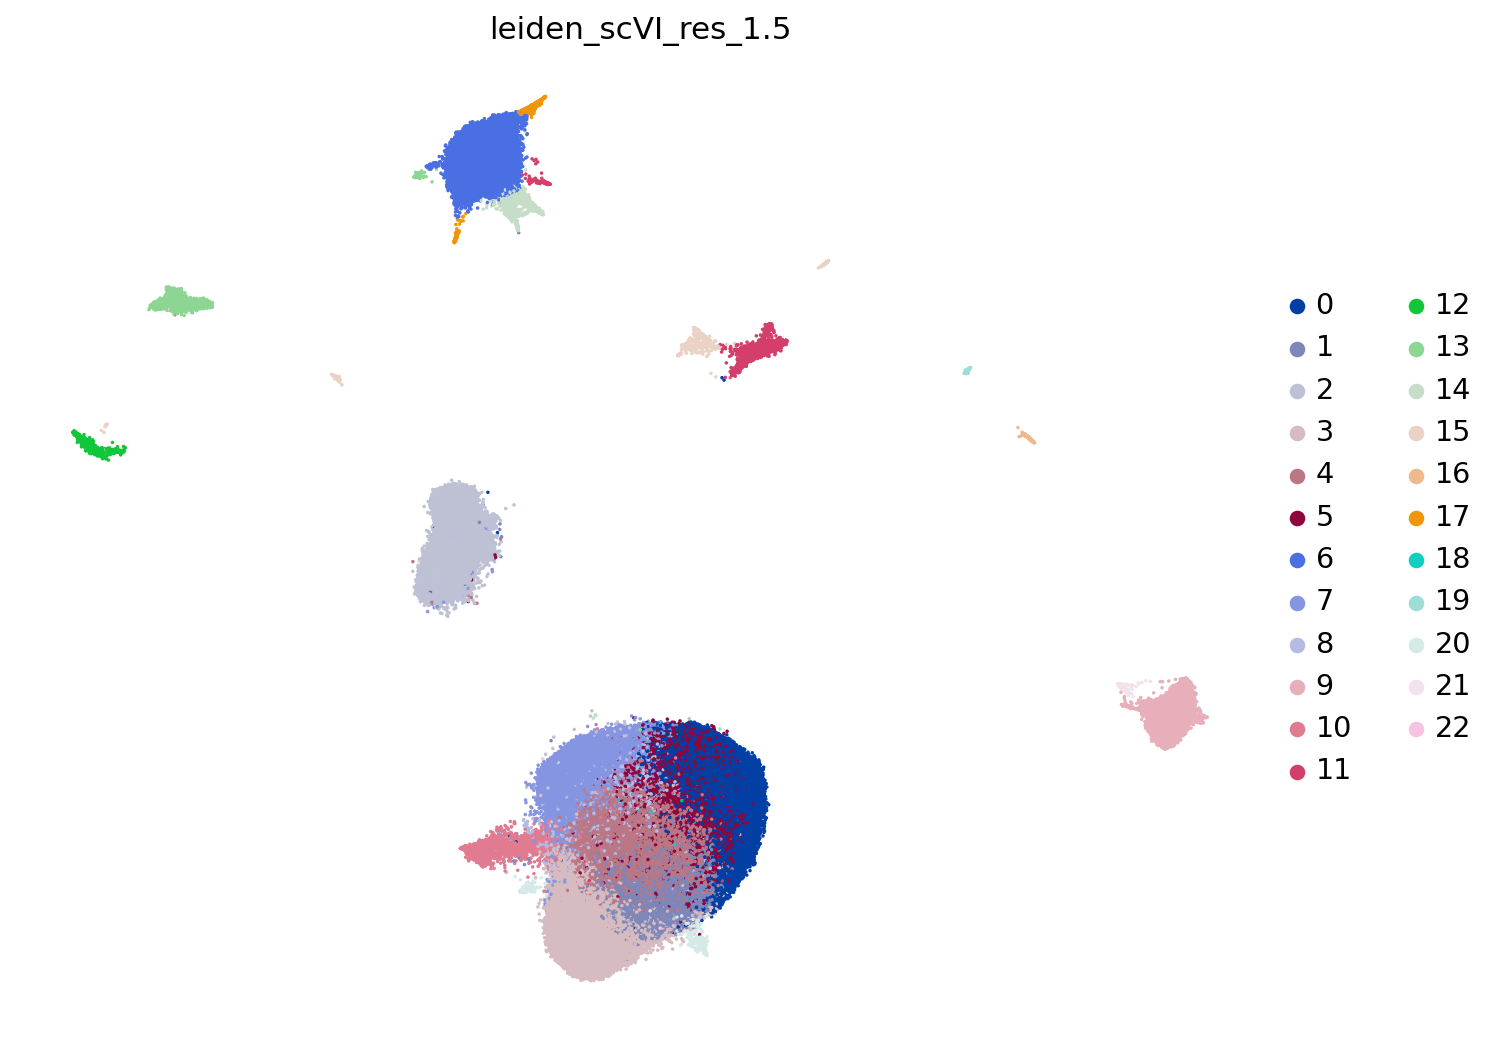

In [23]:
sc.pl.umap(
    adata,
    color=["leiden_scVI_res_1.5"],
    frameon=False,
    size=10,
    save='_Clustering-Res_1.5.pdf'
)

Save AnnData Object

In [28]:
adata.write_h5ad('./Adata_Objects/01b_HVGenes_Clustered.h5ad',compression='gzip')

Load AnnData Object

In [25]:
#adata = ad.read_h5ad('./Adata_Objects/01b_HVGenes_Clustered.h5ad')

## 6. Calculate neighbors and Conduct Leiden Clustering  on adata with ALL GENES

/mnt/home/cholicog/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


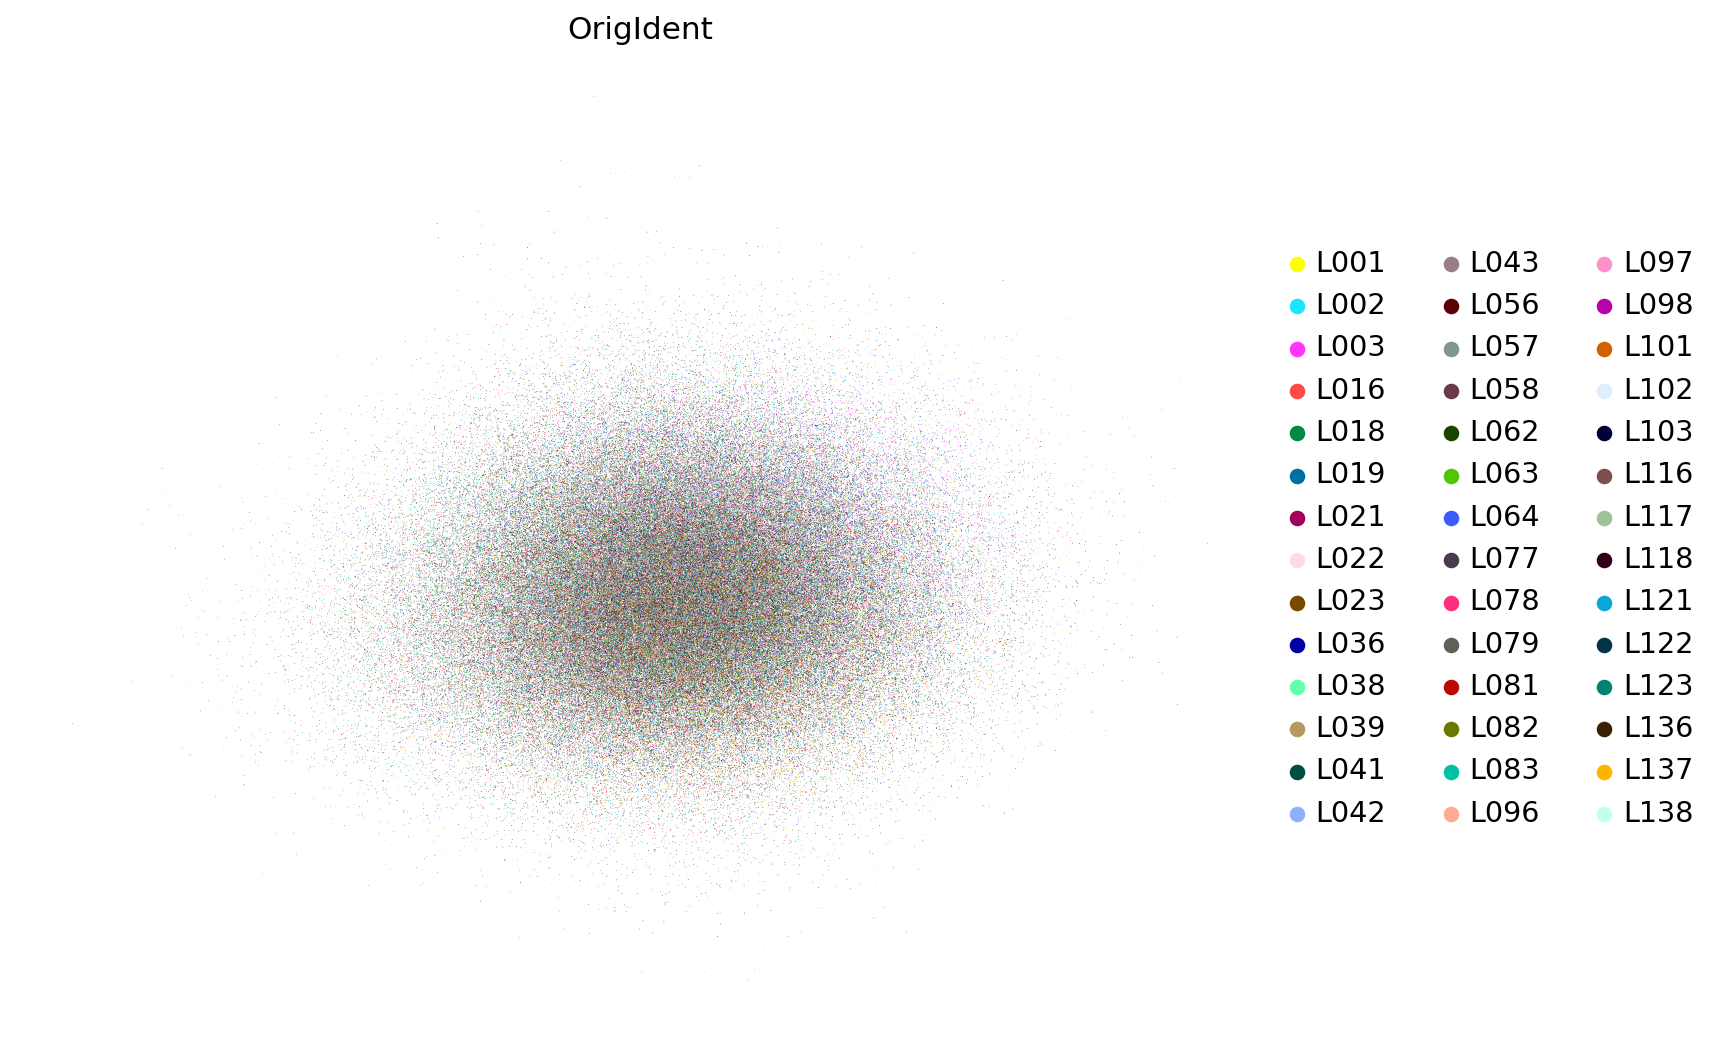

In [24]:
sc.pl.embedding(
    adata_ALL_GENES,
    basis="X_scVI",
    color=["OrigIdent"],
    frameon=False,
    ncols=1,
)

In [25]:
sc.pp.neighbors(adata_ALL_GENES, 
                use_rep="X_scVI",
                random_state=5,
                method='umap')

In [26]:
sc.tl.umap(adata_ALL_GENES, 
           min_dist=0.1,
           random_state=5)

In [27]:
sc.tl.leiden(adata_ALL_GENES, key_added="leiden_scVI_res_0.05", resolution=0.05)
sc.tl.leiden(adata_ALL_GENES, key_added="leiden_scVI_res_0.1", resolution=0.1)
sc.tl.leiden(adata_ALL_GENES, key_added="leiden_scVI_res_0.25", resolution=0.25)
sc.tl.leiden(adata_ALL_GENES, key_added="leiden_scVI_res_0.5", resolution=0.5)
sc.tl.leiden(adata_ALL_GENES, key_added="leiden_scVI_res_0.75", resolution=0.75)
sc.tl.leiden(adata_ALL_GENES, key_added="leiden_scVI_res_1.50", resolution=1.50)

Save AnnData Object

In [29]:
adata_ALL_GENES.write_h5ad('./Adata_Objects/01b_AllGenes_Clustered.h5ad',compression='gzip')

Load AnnData Object

In [ ]:
#adata_ALL_GENES = ad.read_h5ad('./Adata_Objects/01b_AllGenes_Clustered.h5ad')

## 7. Notes and Conclusions

Datasets were integrated and clustered (Leiden Method) in this notebook.